### **This notebook contains scripts for cleaning, transforming, analyzing, and visualizing survey data for a research study. For demonstration purposes, a test dataset containing dummy data (computer generated responses) is used below.**

# **Loading Packages**

In [176]:
import pandas as pd
import re
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import ConnectionPatch
import seaborn as sns

# **Dataset Processing & Cleaning**

In [177]:
# Loading dataset
df_raw = pd.read_csv('/content/test.csv')

In [178]:
# Removing first row containing the question and second row containing 'import id' & resetting column index
df_raw = df_raw.iloc[2:].reset_index(drop=True)
df_raw.shape[0]

325

## Cleaning Columns/Rows
> Renaming/removing unnecessary columns and rows

In [179]:
## Obtaining only the completed responses, assigning it to a new variable 'df', and resetting the index
df = df_raw[df_raw['Finished'] == 'True']
df = df.reset_index(drop=True)
df.shape[0]

247

In [180]:
# @title
# Removing the columns not needed in the analysis and simplifying the view of the dataset
df = df.drop(['StartDate','EndDate','Status','Status','Progress','Duration (in seconds)','Finished','RecordedDate',
              'ResponseId','ResponseId','DistributionChannel','UserLanguage','Q_RecaptchaScore'], axis=1)

In [181]:
# Columns 'Q1', 'Q2', 'Q3' are the independent variables. The following script renames the columns to their respective variable names.
df.rename(columns={'Q1': 'age_group'}, inplace=True)
df.rename(columns={'Q2': 'gender'}, inplace=True)
df.rename(columns={'Q3': 'education'}, inplace=True)

## Transforming Data: Assigning Numerical Values
In this section, each answer choice from the survey will be converted into a numerical value ranging from 0 to 3 in order to perform the statistical analysis (ANOVA) located below.



> **Single answer choices**

> This section concerns only the single choice questions where respondents can only choose 1 answer. Each answer choice is assigned a number from 0 to 1 and then converted into a integer datatype.



In [182]:
# @title
df['Q4'] = df['Q4'].replace({'Yes': 1, 'No': 0}).astype(int)
df['Q5'] = df['Q5'].replace({'Yes': 1, 'No': 0}).astype(int)
df['Q6'] = df['Q6'].replace({'Not familiar at all':0, 'Moderately familiar':1, 'Very familiar':2, 'Extremely familiar':3}).astype(int)
df['Q7'] = df['Q7'].replace({'Not familiar at all':0, 'Moderately familiar':1, 'Very familiar':2, 'Extremely familiar':3}).astype(int)

df['Q8'] = df['Q8'].replace({'No degree required': 0,
                             'High School Diploma or GED': 0,
                             "Associate's Degree (e.g. AA, AS)": 0,
                             "Bachelor's Degree (e.g. BA, BS)": 0,
                             "Master's Degree (e.g. MA, MS)": 1,
                             "Doctorate Degree (e.g. PhD, EdD": 1}).astype(int)

df['Q11'] = df['Q11'].replace({'Not important at all':0, 'Moderately important':1, 'Very important':2, 'Extremely important':3}).astype(int)
df['Q12'] = df['Q12'].replace({'No collaboration':0, 'Minimal collaboration':1, 'Moderate collaboration':2, 'Extensive collaboration':3}).astype(int)
df['Q14'] = df['Q14'].replace({'10-15':0, '16-30':0, '31 and 40':1, '40 and up':1}).astype(int)
df['Q17'] = df['Q17'].replace({'Never':0, 'Sometimes':1, 'Frequently':2, 'Always':3}).astype(int)
df['Q18'] = df['Q18'].replace({'Never':0, 'Sometimes':1, 'Frequently':2, 'Always':3}).astype(int)
df['Q19'] = df['Q19'].replace({'Never':0, 'Sometimes':1, 'Frequently':2, 'Always':3}).astype(int)



> **Multi-select answers choices**

> This section concerns the multi-choice questions where respondents can choose multiple answers in their response. Each answer choice is assigned a 1 so they are equal value.

In [183]:
# Defining a function that splits each different answer choice by a comma and assigning a 1 to each.
def process9(response):
    choices = response.split(',')  # Splits the responses by commas
    return sum([1 if choice.strip() in ['Infants/Newborns', 'School-aged children', 'Adults', 'All stages of life'] else 0 for choice in choices])

# Applying the function to the 'Q9' column
df['Q9'] = df['Q9'].apply(process9)

# Changes datatype to integer
df['Q9'] = df['Q9'].astype(int)

In [184]:
def process10(response):
    choices = response.split(',')
    return sum([1 if choice.strip() in ['Speech teacher', 'Speech therapist', 'Speech Language Pathologist'] else 0 for choice in choices])

df['Q10'] = df['Q10'].apply(process10)

df['Q10'] = df['Q10'].astype(int)

In [185]:
# Renaming the answer choice by removing the comma
## so it does not interfere with the second function below that separates each answer by commas.
def replace_value(response):
    return response.replace("Uniform Services of the United States (e.g. Army, Navy)", "Uniform Services of the United States (e.g. Army Navy)")
df['Q13'] = df['Q13'].apply(replace_value)

# Creating a function to assign numerical value of 1 so each answer choice is equal value and changing to an integer datatype
def process13(response):
    choices = response.split(',')    ## Split the answer choices by commas
    return sum([1 if choice.strip() in ['Hospitals',
                                        'Universities',
                                        'Home Health Practices',
                                        'Uniform Services of the United States (e.g. Army Navy)',
                                        'Public Health Departments',
                                        "Nonresidential Health Care Facilities (e.g. doctor's office)",
                                        'Preschools',
                                        'Prisons',
                                        'Early Intervention Practices',
                                        'Residential Health Care Facilities (e.g. assisted living facilities)',
                                        'Private Practices',
                                        'Private Corporations',
                                        'Schools (e.g. k-12)'] else 0 for choice in choices])
df['Q13'] = df['Q13'].apply(process13)

df['Q13'] = df['Q13'].astype(int)

In [186]:
def process15(response):
    choices = response.split(',')
    return sum([1 if choice.strip() in ['Articulation',
                                        'Fluency',
                                        'Voice',
                                        'Language',
                                        'Hearing',
                                        "Swallowing/Feeding",
                                        'Cognition',
                                        'Social aspects of communication',
                                        'Communication modalities'] else 0 for choice in choices])
df['Q15'] = df['Q15'].apply(process15)

df['Q15'] = df['Q15'].astype(int)

In [187]:
## Columns Q16_1 to Q16_18 are all part of the question 16 and question the same answer choices.
## The script below applies to the columns listed in the 'columns' variable.

columns = ['Q16_1', 'Q16_2', 'Q16_3', 'Q16_4', 'Q16_5', 'Q16_6',
           'Q16_7', 'Q16_8', 'Q16_9', 'Q16_10', 'Q16_11', 'Q16_12',
           'Q16_13', 'Q16_14', 'Q16_15', 'Q16_16', 'Q16_17', 'Q16_18']

def replace_value(response):
    return response.replace("Uniform Services of the United States (e.g. Army, Navy)", "Uniform Services of the United States (e.g. Army Navy)")
df[columns] = df[columns].applymap(replace_value)

def process16(response):
    choices = response.split(',')
    return sum([1 if choice in ["Schools (k-12)",
                                        "Hospitals",
                                        "Nonresidential Health Care Facilities (e.g. doctor's office)",
                                        "Private Practices",
                                        "Residential Health Care Facilities",
                                        "Uniform Services of the United States (e.g. Army Navy)",
                                        "Public Health Departments",
                                        "Private Corporations",
                                        "Home Health",
                                        "Universities",
                                        "Early Intervention",
                                        "Preschool",
                                        "Prisons"] else 0 for choice in choices])
df[columns] = df[columns].applymap(process16)

df[columns] = df[columns].astype(int)

In [188]:
## Once columns Q16_1 to Q16_18 are changed to integers, they are all added up to form a new column called 'Q16'.
df['Q16_1'] = df[['Q16_1', 'Q16_2', 'Q16_3', 'Q16_4', 'Q16_5', 'Q16_6',
                'Q16_7', 'Q16_8', 'Q16_9', 'Q16_10', 'Q16_11', 'Q16_12',
                'Q16_13', 'Q16_14', 'Q16_15', 'Q16_16', 'Q16_17', 'Q16_18']].sum(axis=1)
df.drop(columns=['Q16_2', 'Q16_3', 'Q16_4', 'Q16_5', 'Q16_6',
                'Q16_7', 'Q16_8', 'Q16_9', 'Q16_10', 'Q16_11', 'Q16_12',
                'Q16_13', 'Q16_14', 'Q16_15', 'Q16_16', 'Q16_17', 'Q16_18'], inplace=True)

df.columns = df.columns.str.replace('Q16_1', 'Q16', regex=True)

# **Response Analyses**
> This section conducts descriptive analyses on the responses from survey data. Analyses include:
1. finding the distribution of people in each independent variable category
2. amount of completed versus incompleted responses
3. number of responses for each answer choice

## 1. Distribution of Respondents in Each Independent Variable

In [189]:
total = df.shape[0]  # total COMPLETED responses/rows

ages = ['18-24', '25-34', '35-44','45-54', '55-64','65+']
genders = ['Male', 'Female','Transgender','Nonbinary/nonconforming','Other','Prefer not to respond']
educations = ['Grade school (6-12)','Elementary school','Less than high school diploma','High school diploma or GED',
              'Some college, but no degree', 'Associates Degree (e.g. AA, AS)',"Bachelor's Degree (e.g. BA, BS)",
              "Master's Degree (e.g. MA, MS, MBA, MEng)",'Professional Degree (e.g. MD, DDS, JD)','Doctorate (e.g. PhD, EdD)']

# age_group
print(f'  Count of Age Groups')
for age in ages:
  count1 = df[df['age_group'] == age].shape[0]
  percent1 = round(count1/total * 100, 1)
  print(f'{age}: {count1} people  {percent1}%  ({count1}/{total})')

# gender
print(f'\n  Count of Genders')
for gender in genders:
  count2 = df[df['gender'] == gender].shape[0]
  percent2 = round(count2/total * 100, 1)
  print(f'{gender}: {count2} people  {percent2}%  ({count2}/{total})')

# education
print(f'\n  Count of Educations')
for education in educations:
  count3 = df[df['education'] == education].shape[0]
  percent3 = round(count3/total * 100, 1)
  print(f'{education}: {count3} people  {percent3}%  ({count3}/{total})')

  Count of Age Groups
18-24: 47 people  19.0%  (47/247)
25-34: 42 people  17.0%  (42/247)
35-44: 39 people  15.8%  (39/247)
45-54: 38 people  15.4%  (38/247)
55-64: 39 people  15.8%  (39/247)
65+: 42 people  17.0%  (42/247)

  Count of Genders
Male: 37 people  15.0%  (37/247)
Female: 49 people  19.8%  (49/247)
Transgender: 34 people  13.8%  (34/247)
Nonbinary/nonconforming: 41 people  16.6%  (41/247)
Other: 35 people  14.2%  (35/247)
Prefer not to respond: 51 people  20.6%  (51/247)

  Count of Educations
Grade school (6-12): 22 people  8.9%  (22/247)
Elementary school: 25 people  10.1%  (25/247)
Less than high school diploma: 30 people  12.1%  (30/247)
High school diploma or GED: 21 people  8.5%  (21/247)
Some college, but no degree: 20 people  8.1%  (20/247)
Associates Degree (e.g. AA, AS): 30 people  12.1%  (30/247)
Bachelor's Degree (e.g. BA, BS): 28 people  11.3%  (28/247)
Master's Degree (e.g. MA, MS, MBA, MEng): 21 people  8.5%  (21/247)
Professional Degree (e.g. MD, DDS, JD): 2

> **Charts/Graphs**

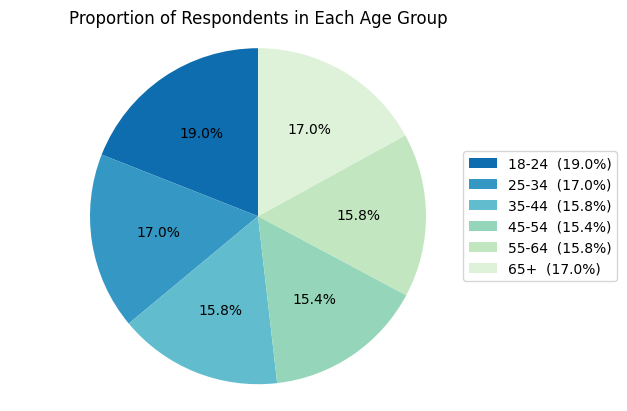

In [219]:
## age_group
age_size = [47, 42, 39, 38, 39, 42]

total = sum(age_size)
percentages = [(size / total) * 100 for size in age_size]

legend_labels = [f'{label}  ({percent:.1f}%)' for label, percent in zip(ages, percentages)]

plt.pie(age_size,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('GnBu')[::-1])
plt.axis('equal')
plt.legend(labels=legend_labels, bbox_to_anchor=(0.9, 0.5), loc="center left")
plt.title('Proportion of Respondents in Each Age Group')
plt.show()

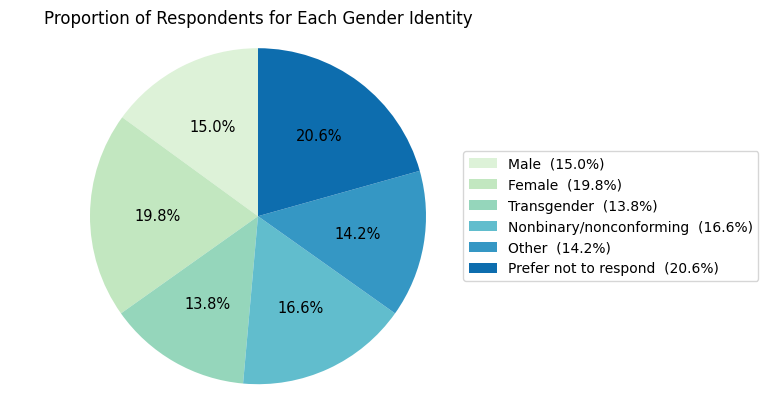

In [253]:
## gender
gender_size = [37, 49, 34, 41, 35, 51]
genders = ['Male', 'Female','Transgender','Nonbinary/nonconforming','Other','Prefer not to respond']

total = sum(gender_size)
percentages = [(size / total) * 100 for size in gender_size]

legend_labels = [f'{label}  ({percent:.1f}%)' for label, percent in zip(genders, percentages)]

plt.pie(gender_size,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize':10.5},
        colors=sns.color_palette('GnBu'))
plt.axis('equal')
plt.legend(labels=legend_labels, bbox_to_anchor=(0.9, 0.5), loc="center left")
plt.title('Proportion of Respondents for Each Gender Identity')
plt.show()

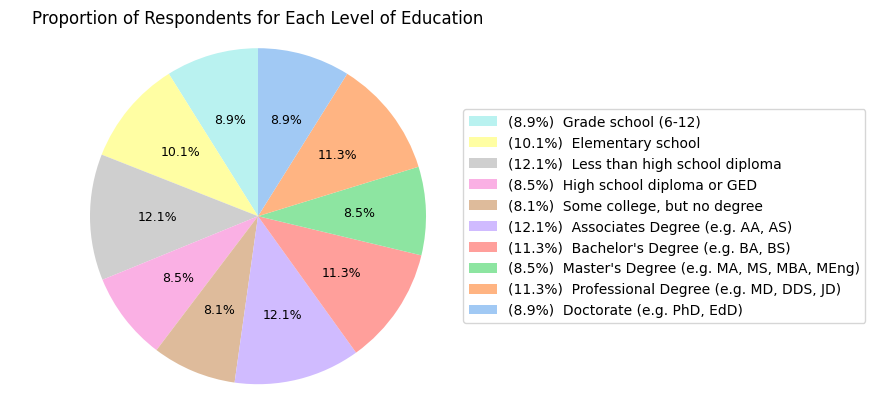

In [254]:
edu = ['Grade school (6-12)','Elementary school','Less than high school diploma','High school diploma or GED',
        'Some college, but no degree', 'Associates Degree (e.g. AA, AS)',"Bachelor's Degree (e.g. BA, BS)",
        "Master's Degree (e.g. MA, MS, MBA, MEng)",'Professional Degree (e.g. MD, DDS, JD)','Doctorate (e.g. PhD, EdD)']

edu_size = [22, 25, 30, 21, 20, 30, 28, 21, 28, 22]

total = sum(edu_size)
percentages = [(size / total) * 100 for size in edu_size]

legend_labels = [f'({percent:.1f}%)  {label}' for label, percent in zip(edu, percentages)]

plt.pie(edu_size, autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 9},
        colors=sns.color_palette('pastel')[::-1])
plt.axis('equal')

plt.legend(labels=legend_labels, bbox_to_anchor=(0.9, 0.5), loc="center left")

plt.title('Proportion of Respondents for Each Level of Education')
plt.show()

## 2. Amount of Incomplete vs. Complete Responses

In [193]:
df_raw['Progress'].unique()

array(['5', '67', '57', '19', '38', '100'], dtype=object)

In [194]:
total = df_raw.shape[0]   #total completed responses/rows

## Completed
complete = df_raw[df_raw['Progress'] == '100'].shape[0]
percent100 = round(complete/total * 100,1)
print(f'Completed responses: {percent100}% ({complete}/{total}) \n')

## Overall Incomplete
overall_incomplete = df_raw[df_raw['Finished'] == 'False'].shape[0]

percent = round(overall_incomplete/total * 100,1)
print(f'Overall Incomplete Responses: {percent}% ({overall_incomplete}/{total}) \n')

progresses = ['5', '19', '38', '57', '67']
for progress in progresses:
    incomplete = df_raw[df_raw['Progress'] == progress].shape[0]
    percent_total = round(incomplete / total * 100, 1)
    percent_overall = round(incomplete / overall_incomplete * 100, 1)

    print(f'    {progress}% Progress \n'
          f'Out of total responses: {percent_total}% ({incomplete}/{total}) \n'
          f'Out of incomplete responses: {percent_overall}% ({incomplete}/{overall_incomplete}) \n')

Completed responses: 76.0% (247/325) 

Overall Incomplete Responses: 24.0% (78/325) 

    5% Progress 
Out of total responses: 2.5% (8/325) 
Out of incomplete responses: 10.3% (8/78) 

    19% Progress 
Out of total responses: 0.9% (3/325) 
Out of incomplete responses: 3.8% (3/78) 

    38% Progress 
Out of total responses: 0.9% (3/325) 
Out of incomplete responses: 3.8% (3/78) 

    57% Progress 
Out of total responses: 1.8% (6/325) 
Out of incomplete responses: 7.7% (6/78) 

    67% Progress 
Out of total responses: 17.8% (58/325) 
Out of incomplete responses: 74.4% (58/78) 



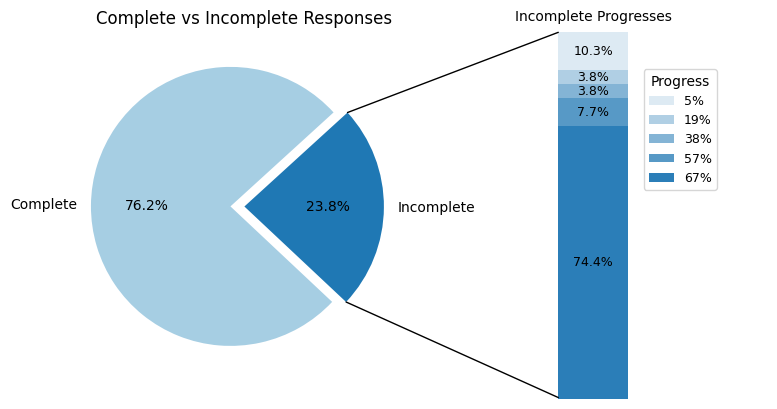

In [216]:
 # make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [.24, .77]
labels = ['Incomplete', 'Complete']
explode = [0, 0.1]
# rotate so that the first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode, colors=sns.color_palette('Paired',2)[::-1])
ax1.set_title('Complete vs Incomplete Responses')

# bar chart parameters
incomplete_ratios = [.103, .038, .038, .077, .744]
incomplete_labels = ['5%', '19%', '38%', '57%', '67%']
bottom = 1
width = .2

# Adding from the top matches the legend.
#for j, (height, label) in enumerate(reversed([*zip(incomplete_ratios, incomplete_labels)])):
for j, (height, label) in enumerate([*zip(incomplete_ratios, incomplete_labels)]):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=min(1.0, 0.15 + 0.2 * j))
    ax2.bar_label(bc, labels=[f"{height:.1%}"], label_type='center', fontsize='9')

ax2.set_title('Incomplete Progresses', y=0.96, fontsize='10')
ax2.legend(bbox_to_anchor=(0.75, 0.7), loc="center", title="Progress", title_fontsize='10', fontsize='9')
ax2.axis('off')
ax2.set_xlim(-2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 1), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0.004), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(1)

plt.show()

## Amount of Responses for Each Answer

In [196]:
df1 = df_raw[df_raw['Finished'] == 'True']
df1.shape[0]

247

In [197]:
columns = ['Q13','Q16_1', 'Q16_2', 'Q16_3', 'Q16_4', 'Q16_5', 'Q16_6',
           'Q16_7', 'Q16_8', 'Q16_9', 'Q16_10', 'Q16_11', 'Q16_12',
           'Q16_13', 'Q16_14', 'Q16_15', 'Q16_16', 'Q16_17', 'Q16_18']

def replace_value(response):
    return response.replace("Uniform Services of the United States (e.g. Army, Navy)", "Uniform Services of the United States (e.g. Army Navy)")
df1[columns] = df1[columns].applymap(replace_value)

<ipython-input-197-62694de57f43>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[columns] = df1[columns].applymap(replace_value)


In [198]:
# Listing out answers/categories for each question
## Single answer choices
total = df.shape[0]    #total completed responses/rows

q4 = ['Yes', 'No']
q5 = ['Yes', 'No']
q6 = ['Not familiar at all', 'Moderately familiar', 'Very familiar', 'Extremely familiar']
q7 = ['Not familiar at all', 'Moderately familiar', 'Very familiar', 'Extremely familiar']
q8 = ['No degree required',
      'High School Diploma or GED',
      "Associate's Degree (e.g. AA, AS)",
      "Bachelor's Degree (e.g. BA, BS)",
      "Master's Degree (e.g. MA, MS)",
      "Doctorate Degree (e.g. PhD, EdD"]
q11 = ['Not important at all', 'Moderately important', 'Very important', 'Extremely important']
q12 = ['No collaboration', 'Minimal collaboration', 'Moderate collaboration', 'Extensive collaboration']
q14 = ['10-15', '16-30', '31 and 40', '40 and up']
q17 = ['Never', 'Sometimes', 'Frequently', 'Always']
q18 = ['Never', 'Sometimes', 'Frequently', 'Always']
q19 = ['Never', 'Sometimes', 'Frequently', 'Always']

## Multiple answer choices
q9 = ['Infants/Newborns', 'School-aged children', 'Adults', 'All stages of life']
q10 = ['Speech teacher', 'Speech therapist', 'Speech Language Pathologist']
q13 = ['Hospitals', 'Universities', 'Home Health Practices', 'Uniform Services of the United States (e.g. Army Navy)', 'Public Health Departments',
      "Nonresidential Health Care Facilities (e.g. doctor's office)", 'Preschools', 'Prisons', 'Early Intervention Practices',
      'Residential Health Care Facilities (e.g. assisted living facilities)', 'Private Practices', 'Private Corporations', 'Schools (e.g. k-12)']
q15 = ['Articulation', 'Fluency', 'Voice', 'Language', 'Hearing', "Swallowing/Feeding",
       'Cognition', 'Social aspects of communication','Communication modalities']
q16 = ['Hospitals', 'Universities', 'Home Health Practices', 'Uniform Services of the United States (e.g. Army Navy)','Public Health Departments',
         "Nonresidential Health Care Facilities (e.g. doctor's office)", 'Preschools', 'Prisons', 'Early Intervention Practices',
         'Residential Health Care Facilities (e.g. assisted living facilities)', 'Private Practices', 'Private Corporations', 'Schools (e.g. k-12)']

In [199]:
print(f'  Question 4')
for choice in q4:
  count4 = df1[df1['Q4'] == choice].shape[0]
  percent4 = round(count4/total * 100, 1)
  print(f'{choice} \t {count4} \t {percent4}% \t ({count4}/{total})')

print(f'\n  Question 5')
for choice in q5:
  count5 = df1[df1['Q5'] == choice].shape[0]
  percent5 = round(count5/total * 100, 1)
  print(f'{choice} \t {count5} \t {percent5}% \t ({count5}/{total})')

print(f'\n  Question 6')
for choice in q6:
  count6 = df1[df1['Q6'] == choice].shape[0]
  percent6 = round(count6/total * 100, 1)
  print(f'{choice} \t {count6} \t {percent6}% \t ({count6}/{total})')

print(f'\n  Question 7')
for choice in q7:
  count7 = df1[df1['Q7'] == choice].shape[0]
  percent7 = round(count7/total * 100, 1)
  print(f'{choice} \t {count7} \t {percent7}% \t ({count7}/{total})')

print(f'\n  Question 8')
for choice in q8:
  count8 = df1[df1['Q8'] == choice].shape[0]
  percent8 = round(count8/total * 100, 1)
  print(f'{choice} \t {count8} \t {percent8}% \t ({count8}/{total})')

print(f'\n  Question 11')
for choice in q11:
  count11 = df1[df1['Q11'] == choice].shape[0]
  percent11 = round(count11/total * 100, 1)
  print(f'{choice} \t {count11} \t {percent11}% \t ({count11}/{total})')

print(f'\n  Question 12')
for choice in q12:
  count12 = df1[df1['Q12'] == choice].shape[0]
  percent12 = round(count12/total * 100, 1)
  print(f'{choice} \t {count12} \t {percent12}% \t ({count12}/{total})')

print(f'\n  Question 14')
for choice in q14:
  count14 = df1[df1['Q14'] == choice].shape[0]
  percent14 = round(count14/total * 100, 1)
  print(f'{choice} \t {count14} \t {percent14}% \t ({count14}/{total})')

print(f'\n  Question 17')
for choice in q17:
  count17 = df1[df1['Q17'] == choice].shape[0]
  percent17 = round(count17/total * 100, 1)
  print(f'{choice} \t {count17} \t {percent17}% \t ({count17}/{total})')

print(f'\n  Question 18')
for choice in q18:
  count18 = df1[df1['Q18'] == choice].shape[0]
  percent18 = round(count18/total * 100, 1)
  print(f'{choice} \t {count18} \t {percent18}% \t ({count18}/{total})')

print(f'\n  Question 19')
for choice in q19:
  count19 = df1[df1['Q19'] == choice].shape[0]
  percent19 = round(count19/total * 100, 1)
  print(f'{choice} \t {count19} \t {percent19}% \t ({count19}/{total})')

####
#### Multi-select questions
###
print(f'\n  Question 9')
for choice in q9:
    count9 = df1['Q9'].apply(lambda x: choice in x.split(',')).sum()
    percent9 = round(count9 / total * 100, 1)
    print(f'{choice} \t {count9} \t {percent9}% \t ({count9}/{total})')

print(f'\n  Question 10')
for choice in q10:
    count10 = df1['Q10'].apply(lambda x: choice in x.split(',')).sum()
    percent10 = round(count10 / total * 100, 1)
    print(f'{choice} \t {count10} \t {percent10}% \t ({count10}/{total})')

print(f'\n  Question 13')
for choice in q13:
    count13 = df1['Q13'].apply(lambda x: choice in x.split(',')).sum()
    percent13 = round(count13 / total * 100, 1)
    print(f'{choice} \t {count13} \t {percent13}% \t ({count13}/{total})')

print(f'\n  Question 15')
for choice in q15:
    count15 = df1['Q15'].apply(lambda x: choice in x.split(',')).sum()
    percent15 = round(count15 / total * 100, 1)
    print(f'{choice} \t {count15} \t {percent15}% \t ({count15}/{total})')

  Question 4
Yes 	 120 	 48.6% 	 (120/247)
No 	 127 	 51.4% 	 (127/247)

  Question 5
Yes 	 141 	 57.1% 	 (141/247)
No 	 106 	 42.9% 	 (106/247)

  Question 6
Not familiar at all 	 64 	 25.9% 	 (64/247)
Moderately familiar 	 60 	 24.3% 	 (60/247)
Very familiar 	 59 	 23.9% 	 (59/247)
Extremely familiar 	 64 	 25.9% 	 (64/247)

  Question 7
Not familiar at all 	 62 	 25.1% 	 (62/247)
Moderately familiar 	 60 	 24.3% 	 (60/247)
Very familiar 	 65 	 26.3% 	 (65/247)
Extremely familiar 	 60 	 24.3% 	 (60/247)

  Question 8
No degree required 	 44 	 17.8% 	 (44/247)
High School Diploma or GED 	 42 	 17.0% 	 (42/247)
Associate's Degree (e.g. AA, AS) 	 39 	 15.8% 	 (39/247)
Bachelor's Degree (e.g. BA, BS) 	 39 	 15.8% 	 (39/247)
Master's Degree (e.g. MA, MS) 	 34 	 13.8% 	 (34/247)
Doctorate Degree (e.g. PhD, EdD 	 49 	 19.8% 	 (49/247)

  Question 11
Not important at all 	 53 	 21.5% 	 (53/247)
Moderately important 	 56 	 22.7% 	 (56/247)
Very important 	 78 	 31.6% 	 (78/247)
Extremely impo

In [200]:
###
## Question 16
###
q16_columns = [f'Q16_{i}' for i in range(1, 19)]
for column in q16_columns:
  print(f'\n  {column}')
  for choice in q16:
        count16 = df1[column].apply(lambda x: choice in x.split(',')).sum()
        percent16 = round(count16 / total * 100, 1)
        print(f'{choice} \t {count16} \t {percent16}% \t ({count16}/{total})')


  Q16_1
Hospitals 	 124 	 50.2% 	 (124/247)
Universities 	 137 	 55.5% 	 (137/247)
Home Health Practices 	 0 	 0.0% 	 (0/247)
Uniform Services of the United States (e.g. Army Navy) 	 132 	 53.4% 	 (132/247)
Public Health Departments 	 128 	 51.8% 	 (128/247)
Nonresidential Health Care Facilities (e.g. doctor's office) 	 139 	 56.3% 	 (139/247)
Preschools 	 0 	 0.0% 	 (0/247)
Prisons 	 121 	 49.0% 	 (121/247)
Early Intervention Practices 	 0 	 0.0% 	 (0/247)
Residential Health Care Facilities (e.g. assisted living facilities) 	 0 	 0.0% 	 (0/247)
Private Practices 	 134 	 54.3% 	 (134/247)
Private Corporations 	 140 	 56.7% 	 (140/247)
Schools (e.g. k-12) 	 0 	 0.0% 	 (0/247)

  Q16_2
Hospitals 	 138 	 55.9% 	 (138/247)
Universities 	 143 	 57.9% 	 (143/247)
Home Health Practices 	 0 	 0.0% 	 (0/247)
Uniform Services of the United States (e.g. Army Navy) 	 132 	 53.4% 	 (132/247)
Public Health Departments 	 144 	 58.3% 	 (144/247)
Nonresidential Health Care Facilities (e.g. doctor's of

# **Anova**
> This section performs a 3-way analysis of variance on the 2 dependent variables from the research question from the study.

In [220]:
df['knowledge'] = df[['Q4','Q5','Q6','Q7','Q9','Q10','Q14','Q15']].sum(axis=1)
df['perception'] = df[['Q8','Q11','Q12','Q13','Q16','Q17','Q18','Q19']].sum(axis=1)

## Knowledge


In [236]:
model = ols('knowledge ~ C(age_group) * C(gender) * C(education)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=3, alpha=0.05)
print(anova_table)

                                          sum_sq     df          F    PR(>F)
Intercept                             289.000000    1.0  26.281917  0.000002
C(age_group)                           28.473290    5.0   0.517877  0.761999
C(gender)                              17.756194    5.0   0.322953  0.897753
C(education)                          186.642353    9.0   1.885936  0.066313
C(age_group):C(gender)                299.898483   25.0   1.090921  0.372913
C(age_group):C(education)             522.971830   45.0   1.056878  0.408291
C(gender):C(education)                593.532037   45.0   1.199474  0.237911
C(age_group):C(gender):C(education)  2831.664754  225.0   1.144507  0.267249
Residual                              857.700000   78.0        NaN       NaN


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 45, but rank is 44
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 225, but rank is 102
  warnings.warn('covariance of constraints does not have full '


## Perception

In [222]:
model = ols('perception ~ C(age_group) * C(gender) * C(education)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
print(anova_table)

                                           sum_sq     df          F  \
Intercept                            11449.000000    1.0  30.961356   
C(age_group)                          1437.435390    5.0   0.777447   
C(gender)                             2602.429191    5.0   1.407542   
C(education)                          2287.691499    9.0   0.687397   
C(age_group):C(gender)                6499.805362   25.0   0.703093   
C(age_group):C(education)            12206.824237   45.0   0.733572   
C(gender):C(education)               14440.327066   45.0   0.867795   
C(age_group):C(gender):C(education)  49123.676358  225.0   0.590420   
Residual                             28843.116667   78.0        NaN   

                                           PR(>F)  
Intercept                            3.572973e-07  
C(age_group)                         5.689249e-01  
C(gender)                            2.308137e-01  
C(education)                         7.181297e-01  
C(age_group):C(gender)       

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 45, but rank is 44
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 225, but rank is 102
  warnings.warn('covariance of constraints does not have full '


## **Average Knowledge and Perception Scores for Each Independent Variable**


### Knowledge

In [223]:
## Age
df.groupby('age_group')['knowledge'].mean()

age_group
18-24    13.446809
25-34    13.761905
35-44    13.948718
45-54    13.789474
55-64    13.307692
65+      14.571429
Name: knowledge, dtype: float64

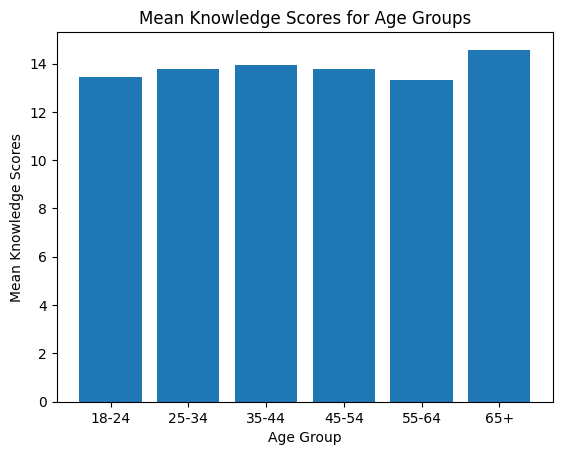

In [255]:
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
mean = [13.446809, 13.761905, 13.948718, 13.789474, 13.307692, 14.571429]

plt.bar(age, mean)
plt.xlabel('Age Group')
plt.ylabel('Mean Knowledge Scores')
plt.title('Mean Knowledge Scores for Age Groups')
plt.show()

In [225]:
## Gender
df.groupby('gender')['knowledge'].mean()

gender
Female                     14.020408
Male                       13.459459
Nonbinary/nonconforming    13.414634
Other                      13.342857
Prefer not to respond      14.470588
Transgender                13.794118
Name: knowledge, dtype: float64

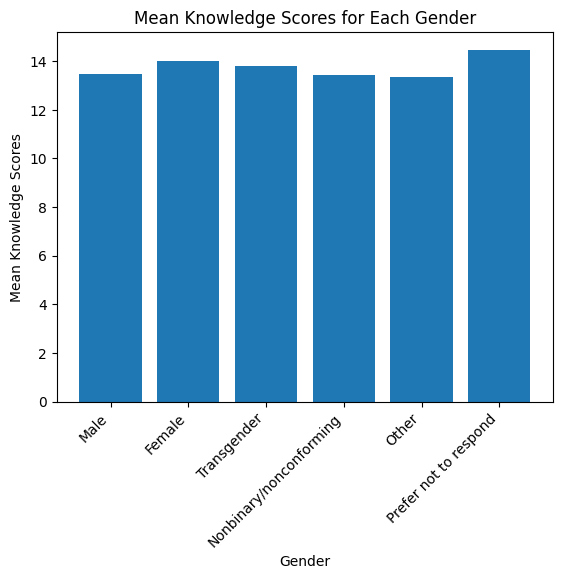

In [266]:
gender = ['Male', 'Female','Transgender','Nonbinary/nonconforming','Other','Prefer not to respond']
mean = [13.459459, 14.020408, 13.794118, 13.414634, 13.342857, 14.470588]

plt.bar(gender, mean)
plt.xlabel('Gender')
plt.ylabel('Mean Knowledge Scores')
plt.title('Mean Knowledge Scores for Each Gender')

plt.xticks(rotation=45, ha='right')

plt.show()

In [227]:
## Education
df.groupby('education')['knowledge'].mean()

education
Associates Degree (e.g. AA, AS)             15.000000
Bachelor's Degree (e.g. BA, BS)             13.892857
Doctorate (e.g. PhD, EdD)                   12.727273
Elementary school                           14.000000
Grade school (6-12)                         13.909091
High school diploma or GED                  14.333333
Less than high school diploma               13.100000
Master's Degree (e.g. MA, MS, MBA, MEng)    13.619048
Professional Degree (e.g. MD, DDS, JD)      13.571429
Some college, but no degree                 13.700000
Name: knowledge, dtype: float64

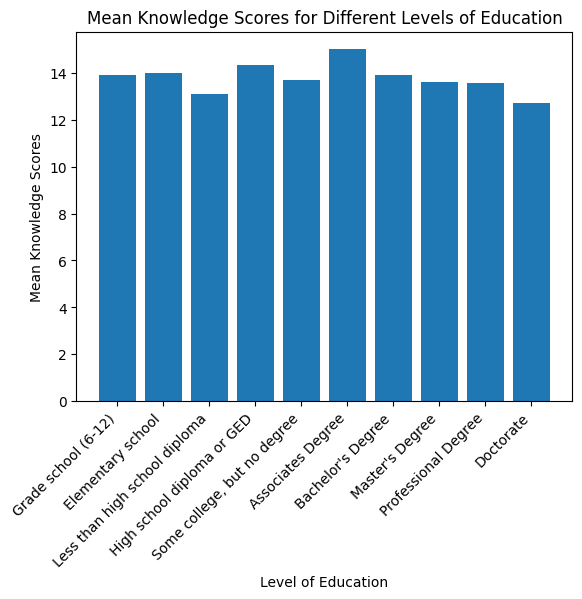

In [262]:
edu = ['Grade school (6-12)',
       'Elementary school',
       'Less than high school diploma',
       'High school diploma or GED',
       'Some college, but no degree',
       'Associates Degree',
       "Bachelor's Degree",
       "Master's Degree",
       'Professional Degree',
       'Doctorate']

mean = [13.909091, 14.000000, 13.100000, 14.333333, 13.700000, 15.000000, 13.892857, 13.619048, 13.571429, 12.727273]

plt.bar(edu, mean)
plt.xlabel('Level of Education')
plt.ylabel('Mean Knowledge Scores')
plt.title('Mean Knowledge Scores for Different Levels of Education')
plt.xticks(rotation=45, ha='right')
plt.show()

### Perception

In [229]:
## Age
df.groupby('age_group')['perception'].mean()

age_group
18-24    138.702128
25-34    141.833333
35-44    140.974359
45-54    139.473684
55-64    142.641026
65+      144.000000
Name: perception, dtype: float64

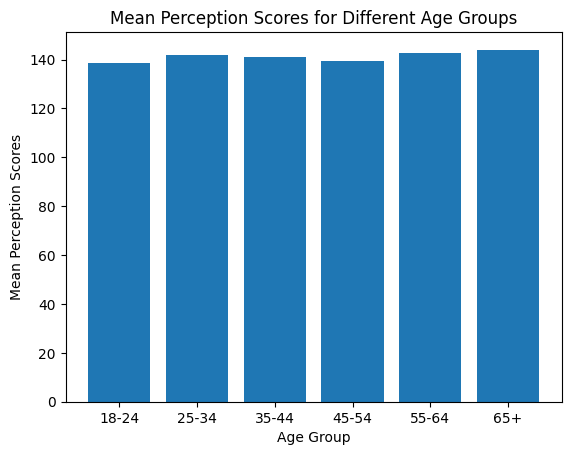

In [267]:
age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
mean_values = [138.702128, 141.833333, 140.974359, 139.473684, 142.641026, 144.000000]

plt.bar(age, mean_values)

plt.xlabel('Age Group')
plt.ylabel('Mean Perception Scores')
plt.title('Mean Perception Scores for Different Age Groups')

plt.show()

In [231]:
## Gender
df.groupby('gender')['perception'].mean()

gender
Female                     138.836735
Male                       142.864865
Nonbinary/nonconforming    139.951220
Other                      137.342857
Prefer not to respond      145.313725
Transgender                142.352941
Name: perception, dtype: float64

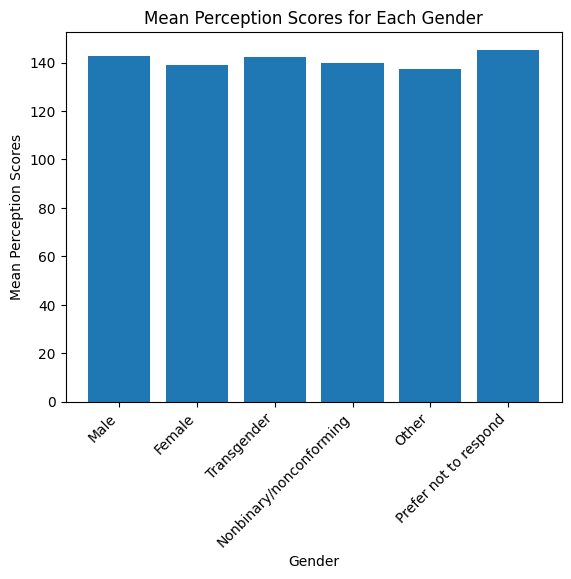

In [265]:
genders = ['Male', 'Female','Transgender','Nonbinary/nonconforming','Other','Prefer not to respond']
mean = [142.864865, 138.836735, 142.352941, 139.951220, 137.342857, 145.313725]

plt.bar(genders, mean)

plt.xlabel('Gender')
plt.ylabel('Mean Perception Scores')
plt.title('Mean Perception Scores for Each Gender')

plt.xticks(rotation=45, ha='right')

plt.show()

In [233]:
## Education
df.groupby('education')['perception'].mean()

education
Associates Degree (e.g. AA, AS)             141.700000
Bachelor's Degree (e.g. BA, BS)             140.178571
Doctorate (e.g. PhD, EdD)                   143.409091
Elementary school                           150.360000
Grade school (6-12)                         139.909091
High school diploma or GED                  138.333333
Less than high school diploma               143.200000
Master's Degree (e.g. MA, MS, MBA, MEng)    138.952381
Professional Degree (e.g. MD, DDS, JD)      133.750000
Some college, but no degree                 142.650000
Name: perception, dtype: float64

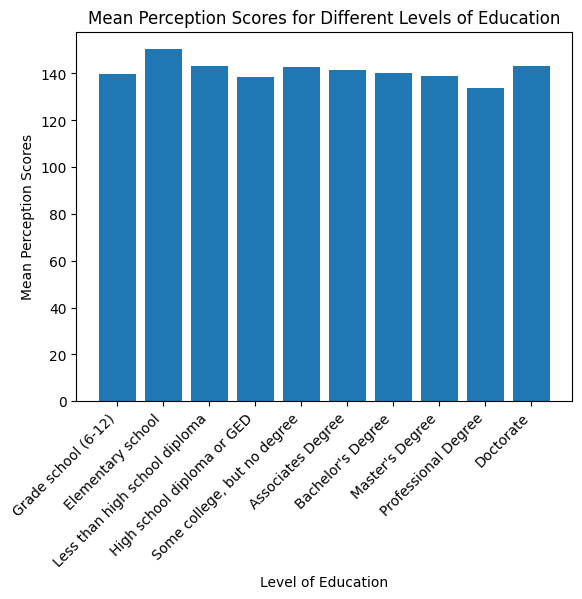

In [263]:
edu = ['Grade school (6-12)',
       'Elementary school',
       'Less than high school diploma',
       'High school diploma or GED',
       'Some college, but no degree',
       'Associates Degree',
       "Bachelor's Degree",
       "Master's Degree",
       'Professional Degree',
       'Doctorate']
mean = [139.909091, 150.360000, 143.200000, 138.333333, 142.650000, 141.700000, 140.178571, 138.952381, 133.750000, 143.409091]

plt.bar(edu, mean)

plt.xlabel('Level of Education')
plt.ylabel('Mean Perception Scores')
plt.title('Mean Perception Scores for Different Levels of Education')

plt.xticks(rotation=45, ha='right')

plt.show()

# **Q20: Sentiment Analysis**
Q20 is an open-ended question with qualitative textual data. Responses are analyzed with the nltk sentiment analysis tool.

In [ ]:
## Assigning Q20 to variable df20 and dropping NaN/missing values
df20 = df[['Q20']].dropna().reset_index(drop=True)

In [ ]:
# number of blank responses
print(f"Number of blank responses: {df['Q20'].isna().sum()}")

Number of blank responses: 3


In [ ]:
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Apply sentiment analysis to DataFrame
df20['sentiment_score'] = df20['Q20'].apply(sid.polarity_scores)

# calculate compund scores
df20['compound'] = df20['sentiment_score'].apply(lambda score: score['compound'])

def compoundscore(x):
  if x <= -0.05:
    return 'negative'
  elif x >= 0.05:
    return 'positive'
  else:
    return 'neutral'

# Assign a text value based on the compound score
df20['Overall Sentiment'] = df20['compound'].apply(compoundscore)

In [ ]:
sentiment_counts = df20['Overall Sentiment'].value_counts()

total = len(df)

for sentiment, count in sentiment_counts.items():
    percent = round(count / total * 100, 1)
    print(f'{sentiment} \t {count} \t {percent}% \t ({count}/{total})')

count = df['Q20'].isna().sum()
percent = round(count / total * 100, 1)
print(f'no response \t {count} \t {percent}% \t ({count}/{total})')

positive 	 65 	 48.1% 	 (65/135)
neutral 	 46 	 34.1% 	 (46/135)
negative 	 21 	 15.6% 	 (21/135)
no response 	 3 	 2.2% 	 (3/135)


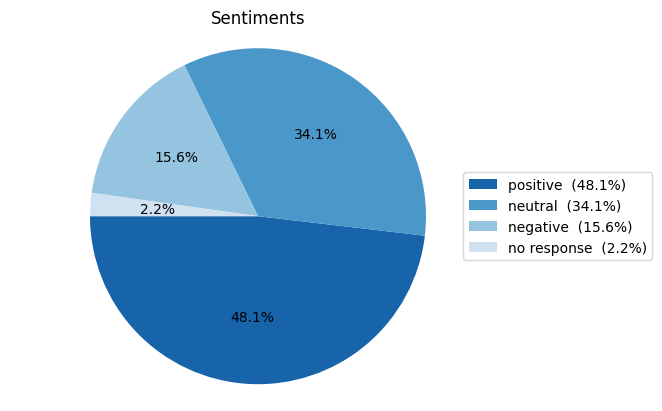

In [ ]:
sizes = [65, 46, 21, 3]
ss = ['positive', 'neutral', 'negative', 'no response']
total = len(df)
percentages = [(size / total) * 100 for size in sizes]

# Create a custom legend with labels containing both the name and percentage
legend_labels = [f'{label}  ({percent:.1f}%)' for label, percent in zip(ss, percentages)]

plt.pie(sizes,
        autopct='%1.1f%%',
        startangle=180,
        colors=sns.color_palette('Blues',4)[::-1])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(labels=legend_labels, bbox_to_anchor=(0.9, 0.5), loc="center left")
plt.title('Sentiments')
plt.show()